In [36]:
import torch
import torch.nn as nn
from torch.nn.functional import *
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import math
import matplotlib.animation as animation
from sklearn.metrics import pairwise_distances
from mpl_toolkits import mplot3d
from matplotlib.pyplot import figure
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [37]:
# def Ham(y):
#     #Hamiltonian of FK_model
#     #Parameters: rho = 0.5 lamda = 300**(-1.5)
#     return 0.5*(y[2]**2+y[3]**2)-torch.cos(y[0])-torch.cos(y[1])+0.5*g*(y[1]-y[0])**2

# def Ham(y):
#     #Hamiltonian of Harmonic Oscilliator
#     #Parameters: rho = 0.5 lamda = 300**(-1.5)
#     return 0.5*torch.sum(torch.square(y))

# def Ham(y):
#     #Hamiltonian of Henon-Heiles System
#     #Parameters: rho = 0.5 lamda = 300**(-1.5)
#     return 0.5*torch.sum(torch.square(y)) + y[0]**2*y[1]+y[1]**3/3.0

# def Ham(y):
#     #Hamiltonian of Two Body Problem
#     #Parameters: rho = 0.3 lamda = 300**(-0.5)
#     return 0.5*torch.norm(y[2:], p=2) - 1.0/torch.norm(torch.norm(y[:2], p=2))

# def Ham(y):
#     #Hamiltonian of Three Body Problem
# #     Parameters: rho = 0.3, lamda = 1500**(-0.5)
#     return 0.5*torch.sum(torch.square(y[2:]))+y[2]*y[1]-y[3]*y[0]-0.5/torch.sqrt((y[0]+0.5)**2+y[1]**2)-0.5/torch.sqrt((y[0]-0.5)**2+y[1]**2)

coeff = 3
# Define a highly nonconvex Hamiltonian funtion
def Ham(y):
    return 0.5*(y[2]**2+y[3]**2)+torch.sin(2 * torch.pi * y[0] / coeff) * torch.cos(2 * torch.pi * y[1] / coeff) + torch.sin(torch.sqrt(y[0]**2 + y[1]**2)) / (torch.sqrt(y[0]**2 + y[1]**2))

# def Ham(y):
#     #Hamiltonian of Double Pendulum
#     l = 2.5
#     m = 1
#     g = 9.8
#     h = 0.01
#     return (y[2]**2+2*y[3]**2-2*y[2]*y[3]*torch.cos(y[0]-y[1]))/(2*m*l**2*(1+torch.sin(y[0]-y[1])**2))+m*g*l*(4-2*torch.cos(y[0])-torch.cos(y[1]))

# def Ham(y):
#     #Hamiltonian that is by construction in the RKHS
#     return torch.exp(-torch.norm(y,p=2) / (2 * 1 **2))

In [38]:
def K(x, y, rho):
    # Compute pairwise value of RBF/Gaussian kernel
    distances = torch.cdist(x, y, p=2)
    kernel_matrix = torch.exp(-distances**2 / (2 * rho **2))
    return kernel_matrix
    

def Gram(data, rho):
    # Compute the Ususal Gram matrix 
    num_points = data.size(0)

    # Reshape data to (N, 1, D) and (1, N, D) to allow broadcasting
    data_i = data.view(num_points, 1, -1)
    data_j = data.view(1, num_points, -1)

    # Compute the Gram matrix using vectorized operations
    gram_matrix = K(data_i, data_j, rho).view(num_points, num_points)

    return gram_matrix

def Gram_single(train_data, data, rho):
    #Usual Gram matrix, with one data point evaluation
    num_points = train_data.size(0)
    data_i = train_data.view(num_points,1,-1)
    data_j = data.view(1,1,-1)
    gram_matrix = K(data_i, data_j, rho).view(num_points, 1)
    return gram_matrix

def K_1_Gram_single(train_data, data, rho):
    #Compute derivative of the Kernel with only the first component, with one data point evaluation
    return ((-1.0/rho**2)*Gram_single(train_data, data, rho)*(train_data-data)).flatten()

def K_1_2(train_data, rho):
    #Compute the Differential Gram matrix
    n, d = train_data.shape
    view1 = train_data.view(n,1,d,1)
    view2 = train_data.view(1,n,d,1)
    diff1 = view1-view2
    diff2 = diff1.view(n,n,1,d)
    temp = torch.matmul(diff1, diff2)
    temp = torch.cat(list(temp),1)
    temp = torch.cat(list(temp),1)
    temp = (-1/rho**4)*temp+(1/rho**2)*torch.tile(torch.eye(d),(n,n))
    scalar = Gram(train_data, rho)
    scalar = torch.permute(scalar.expand(d**2,n,n),(1,2,0)).view(n,n,d,d)
    scalar = torch.cat(list(scalar),1)
    scalar = torch.cat(list(scalar),1)
    return scalar*temp

def K_1_2_Gram_single(train_data, data, rho):
    #Compute the Differential Gram matrix, with one data point evaluation
    n, d = train_data.shape
    view1 = train_data.view(n,1,d,1)
    view2 = data.view(1,1,d,1)
    diff1 = view1-view2
    diff2 = diff1.view(n,1,1,d)
    temp = torch.matmul(diff1, diff2)
    temp = torch.cat(list(temp),1)
    temp = torch.cat(list(temp),1)
    temp = (-1/rho**4)*temp+(1/rho**2)*torch.tile(torch.eye(d),(n,1))
    scalar = Gram_single(train_data, data, rho)
    scalar = torch.permute(scalar.expand(d**2,n,1),(1,2,0)).view(n,1,d,d)
    scalar = torch.cat(list(scalar),1)
    scalar = torch.cat(list(scalar),1)
    return scalar*temp

def coefficients_c(data, vec_field, lamda, rho):
    #Compute the coefficient c for the Differential Representer's Theorem
    n,d = data.size()
    block = np.block([[np.zeros((d//2,d//2)), np.eye(d//2)],[-np.eye(d//2), np.zeros((d//2,d//2))]])
    J = torch.block_diag(*[torch.tensor(block, dtype = torch.float32)]*n)
    return torch.linalg.inv(K_1_2(data, rho)+lamda*n*torch.eye(n*d))@(J.T)@vec_field

def Ham_Vec_Field(data, sigma):
    #Compute the Hamiltonian Vector Field of a given Hamiltonian
    data = torch.tensor(data, requires_grad = True)
    J = torch.tensor([[0,0,1,0],[0,0,0,1],[-1,0,0,0],[0,-1,0,0]], dtype=torch.float32)
    H = Ham(data)
    H.backward()
    np.random.seed(0)
    torch.manual_seed(0)
    return J@data.grad+torch.normal(0, sigma, size=data.size())

def prediction(data, rho):
    #Compute the final estimator of the Hamiltonian function
    return torch.inner(c_hat, K_1_Gram_single(train_data, data, rho))

def Prediction_Ham_Vec_Field(train_data, data, c_hat, rho):
    #Compute the Hamiltonian Vector Field of the Estimated Hamiltonian
    n,d = train_data.shape
    J = torch.tensor([[0,0,1,0],[0,0,0,1],[-1,0,0,0],[0,-1,0,0]], dtype=torch.float32)
    return (J@((K_1_2_Gram_single(train_data, data, rho).view(n,d,d)@c_hat.view(n,d,1)).sum(axis=0))).flatten()

def get_train_error(train_data, train_vec_field, c_hat, rho):
    n, d = train_data.size()
    pred_Ham_vec_field = torch.zeros(n*d)

    for i in range(n):
        temp = Prediction_Ham_Vec_Field(train_data, train_data[i], c_hat, rho)
        pred_Ham_vec_field[i*d:(i+1)*d] = temp
    pred_Ham_vec_field = pred_Ham_vec_field.resize(n,d)
    train_vec_field = train_vec_field.resize(n,d)
    return torch.mean(torch.norm(train_vec_field-pred_Ham_vec_field, p = 2, dim = 1))

def get_test_error(train_data, test_data, test_vec_field, c_hat, rho):
    n, d = test_data.size()
    pred_Ham_vec_field = torch.zeros(n*d)

    for i in range(n):
        temp = Prediction_Ham_Vec_Field(train_data, test_data[i], c_hat, rho)
        pred_Ham_vec_field[i*d:(i+1)*d] = temp
    pred_Ham_vec_field = pred_Ham_vec_field.resize(n,d)
    test_vec_field = test_vec_field.resize(n,d)
    return torch.mean(torch.norm(test_vec_field-pred_Ham_vec_field, p = 2, dim = 1))

In [39]:
def run_optimized_cross_validation(M_list, rho_list, c_list, cv):
    '''
    Grid Search and Cross Validation for Hyperparameter Tunning
    '''
    for M in M_list:
        sigma = 0
        lim = 3
        train_data = []
        for _ in range(M):
            q_a_1 = np.random.rand()*2*lim-lim
            q_a_2 = np.random.rand()*2*lim-lim
            p_a_1 = np.random.rand()*2*lim-lim
            p_a_2 = np.random.rand()*2*lim-lim
            train_data.append([q_a_1,q_a_2,p_a_1,p_a_2])
        train_data = torch.tensor(train_data, dtype = torch.float32, requires_grad = True)
        n, d = train_data.size()
        train_vec_field = torch.zeros(n*d)
        for i in range(n):
            train_vec_field[d*i:d*(i+1)] = Ham_Vec_Field(train_data[i], sigma)
        error_list = []
        for rho in rho_list:
            for c in c_list:
                lamda = c*M**(-0.4)
                #Generating Training Data
                temp_error = 0
                for k in range(cv):
                    temp_train_data = torch.cat((train_data[:k*(n//cv)], train_data[(k+1)*(n//cv):]))
                    temp_train_vec_field = torch.cat((train_vec_field[:k*d*(n//cv)], train_vec_field[(k+1)*d*(n//cv):]))
                    temp_test_data = train_data[k*(n//cv):(k+1)*(n//cv)]
                    temp_test_vec_field = train_vec_field[k*d*(n//cv):(k+1)*d*(n//cv)]
                    #Training Phase
                    c_hat = coefficients_c(temp_train_data, temp_train_vec_field, lamda, rho)
                    temp_error += get_test_error(temp_train_data, temp_test_data, temp_test_vec_field, c_hat, rho).detach().numpy().item()
                error_list.append((temp_error/cv, (rho,c)))
        error, best_params = min(error_list, key = lambda x: x[0])
        print("Number of Samples:", M, "Optimal rho:", best_params[0], "Optimal c:", best_params[1], "Error:", error)

In [40]:
# import time
# start_time = time.time()
# run_optimized_cross_validation([1000],np.arange(0.2,2,0.2), [0.0000005, 0.000001, 0.000005,0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.01], 5)
# print("The programme takes", (time.time() - start_time)//60, "minutes")

In [41]:
rho = 1.2
M=1000
lamda = 5.0/10**7*M**(-0.4)

sigma = 0
lim = 3

#Generating Training Data
train_data = []

for _ in range(M):

    q_a_1 = np.random.rand()*2*lim-lim
    q_a_2 = np.random.rand()*2*lim-lim
    p_a_1 = np.random.rand()*2*lim-lim
    p_a_2 = np.random.rand()*2*lim-lim
    train_data.append([q_a_1,q_a_2,p_a_1,p_a_2])

train_data = torch.tensor(train_data, dtype = torch.float32, requires_grad = True)
n, d = train_data.size()
train_vec_field = torch.zeros(n*d)
for i in range(n):
    train_vec_field[d*i:d*(i+1)] = Ham_Vec_Field(train_data[i], sigma)
#Training Phase
c_hat = coefficients_c(train_data, train_vec_field, lamda, rho)

/var/folders/mh/ml0ws0cd405fvf5vf8vkrfn80000gn/T/ipykernel_96851/2143899961.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, requires_grad = True)


In [42]:
get_train_error(train_data, train_vec_field, c_hat, rho)

/Users/daiyingyin/opt/miniconda3/lib/python3.9/site-packages/torch/_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


tensor(0.0383, grad_fn=<MeanBackward0>)

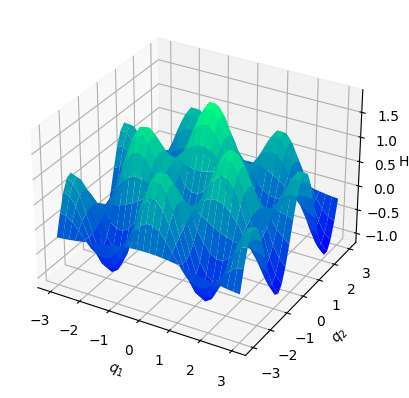

In [43]:
#Plot Ground Truth Hamiltonian
x = np.linspace(-1*lim, lim, 30)
y = np.linspace(-1*lim, lim, 30)

X, Y = np.meshgrid(x, y)
Z = torch.zeros((30,30))
for i in range(30):
    for j in range(30):
        Z[i,j] = Ham(torch.tensor([x[i],y[j],0,0], dtype=torch.float64))

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap=plt.get_cmap('winter'))
ax.set_xlabel('$q_1$')
ax.set_ylabel('$q_2$')
ax.set_zlabel('H', rotation=0)
ax.zaxis.labelpad=-1
plt.savefig("Groundtruth_Double_Pendulum.pdf", bbox_inches='tight')
plt.show()

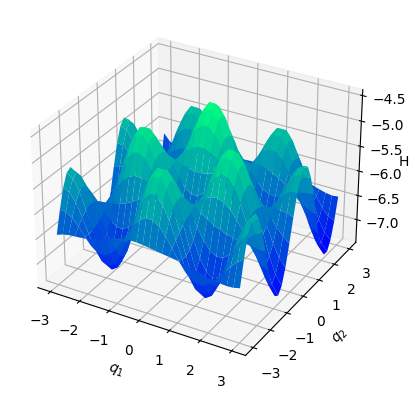

In [44]:
#Plot Predicted Hamiltonian
x = np.linspace(-1*lim, lim, 30)
y = np.linspace(-1*lim, lim, 30)

X, Y = np.meshgrid(x, y)
Z = torch.zeros((30,30))
for i in range(30):
    for j in range(30):
        Z[i,j] = prediction(torch.tensor([x[i],y[j],0,0], dtype=torch.float32), rho)
Z = Z.detach().numpy()

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap=plt.get_cmap('winter'))
ax.set_xlabel('$q_1$')
ax.set_ylabel('$q_2$')
ax.set_zlabel('H', rotation=0)
ax.zaxis.labelpad=-1
plt.savefig("Learned_Double_Pendulum.pdf", bbox_inches='tight')
plt.show()

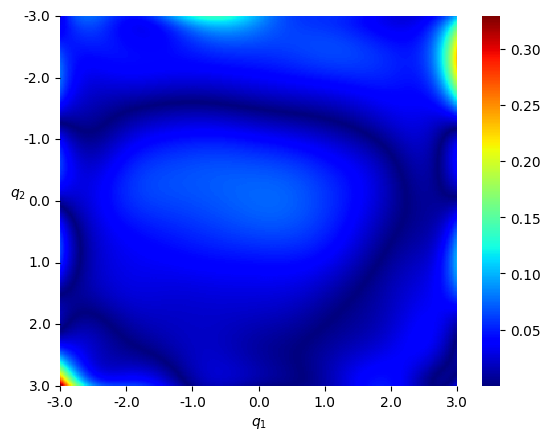

In [45]:
#Plot Absolute Error between the Groundtruth and the Predicted Hamiltonian
grid = 300
x = np.linspace(-1*lim, lim, grid)
y = np.linspace(-1*lim, lim, grid)

X, Y = np.meshgrid(x, y)
Z1 = torch.zeros((grid,grid))
for i in range(grid):
    for j in range(grid):
        Z1[i,j] = Ham(torch.tensor([x[i],y[j],0,0], dtype=torch.float64))
        
Z2 = torch.zeros((grid,grid))
for i in range(grid):
    for j in range(grid):
        Z2[i,j] = prediction(torch.tensor([x[i],y[j],0,0], dtype=torch.float32), rho)

distance = torch.mean((Z1-Z2))
Ham_abs_error = torch.abs(Z1-(Z2+distance)).detach().numpy()

ax = sns.heatmap(Ham_abs_error, cmap='jet')
ax.set_xticks(np.linspace(0,300,7))
ax.set_xticklabels(f'{c:.1f}' for c in range(-3,4))
ax.set_yticks(np.linspace(0,300,7))
ax.set_yticklabels(f'{c:.1f}' for c in range(-3,4))
plt.xticks(rotation=0)
plt.xlabel("$q_1$")
plt.ylabel("$q_2$", rotation=0)
# plt.savefig("Error_Nonconvex_sigma=0.1_M=400.pdf", bbox_inches='tight')
plt.show()